# Emotion Detection in the Eyes

In [47]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
from utils import *
import os
import random

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Prepare data

In [48]:
# Image transformations for training (with data augmentation)
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to grayscale (3 channel)
    transforms.Resize((24, 96)),  # Resize to 24x96 for uniformity
    transforms.RandomRotation(15),  # Random rotation up to 15 degrees
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip with 50% probability
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.3),  # Random blur
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to range [-1, 1]
])

# Transforms for validation and testing (no data augmentation, only resizing and normalization)
test_val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to grayscale (3 channel)
    transforms.Resize((96, 96)),  # Resize to 96x96 for uniformity
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to range [-1, 1]
])

In [49]:
# Path to the dataset folder
dataset_path = r'..\data'

# Load datasets separately with different transforms for train, val, and test
full_dataset = ImageFolder(root=dataset_path, transform=train_transforms)  # Use train transforms initially

# Split the dataset into training, validation, and testing sets (use 80/10/10 split)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Randomly split the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Apply the appropriate transforms to each split (since train/val/test require different transforms)
train_dataset.dataset.transform = train_transforms  # Augmentations are only applied to training data
val_dataset.dataset.transform = test_val_transforms  # No augmentations for validation data
test_dataset.dataset.transform = test_val_transforms  # No augmentations for testing data

# Print sizes of the datasets
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 50668
Validation set size: 6333
Test set size: 6334


In [50]:
# Set batch size
batch_size = 128

# Create DataLoader objects for each dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Display the number of batches in each DataLoader
print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Number of batches in val loader: {len(val_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")

Number of batches in train loader: 396
Number of batches in val loader: 50
Number of batches in test loader: 50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.58431375].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..0.41176474].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.5529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.7803921

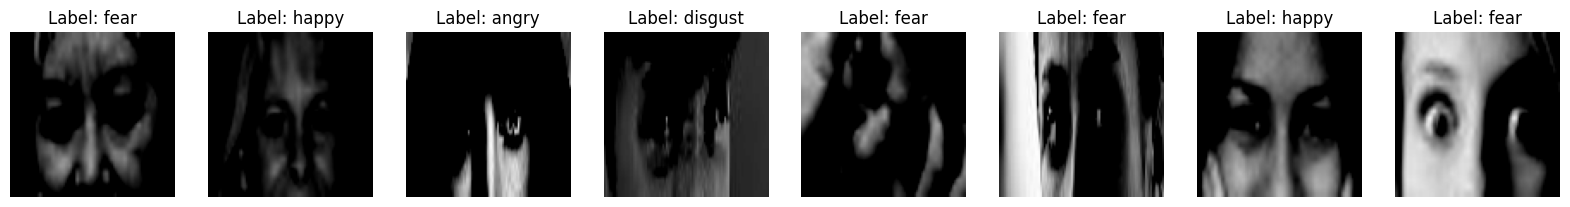

In [51]:
# Call the function to randomly display images from the train dataset
show_random_images_batch(train_dataset, full_dataset.classes, num_images=8)

In [52]:
# Store tracked values for model evaluation
train_losses = []
val_losses = []

# Train Model

In [23]:
from model import EmotionClassifier

# Hyperparameters
num_epochs = 20
learning_rate = 0.001
patience = 5  # Early stopping patience
best_val_loss = float('inf')
early_stop_counter = 0
checkpoint_path = rf'..\checkpoints\best_model_{int(time.time())}.pth'

# Model, Loss, Optimizer
model = EmotionClassifier(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# To track the best model
best_val_accuracy = 0.0

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    return epoch_loss

def validate(model, val_loader, criterion, device):
    """Validate the model and calculate metrics."""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            
            # Get predictions
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss = running_loss / len(val_loader)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return val_loss, accuracy, precision, recall, f1

def test(model, test_loader, device):
    """Evaluate the model on the test set."""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Get predictions
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate final test metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print("\nTest Metrics:")
    print(f"Accuracy:  {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall:    {recall * 100:.2f}%")
    print(f"F1 Score:  {f1 * 100:.2f}%")
    
    return accuracy, precision, recall, f1, all_labels, all_preds

# Training Loop
for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    
    # Train for one epoch
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)  # Store train loss

    # Validate after the epoch
    val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)  # Store validation loss

    # Print epoch metrics
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Val Precision: {val_precision * 100:.2f}% | Val Recall: {val_recall * 100:.2f}% | Val F1 Score: {val_f1 * 100:.2f}%")
    
    # Early Stopping Check
    if val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving best model.")
        best_val_loss = val_loss
        best_val_accuracy = val_accuracy
        early_stop_counter = 0
        
        # Save best model weights
        torch.save(model.state_dict(), checkpoint_path)
    else:
        early_stop_counter += 1
        print(f"Validation loss did not improve. Early stop counter: {early_stop_counter}/{patience}")
        
    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        break

# Load the best model weights
model.load_state_dict(torch.load(checkpoint_path))

# Final test set evaluation
test_accuracy, test_precision, test_recall, test_f1, all_labels, all_preds = test(model, test_loader, device)

c:\Users\najib\anaconda3\envs\EEP568\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\najib\anaconda3\envs\EEP568\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\najib\anaconda3\envs\EEP568\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_t


Epoch [1/20]
Train Loss: 1.5465 | Val Loss: 1.4742 | Val Accuracy: 41.34%
Val Precision: 43.12% | Val Recall: 41.34% | Val F1 Score: 41.57%
Validation loss improved from inf to 1.4742. Saving best model.

Epoch [2/20]


c:\Users\najib\anaconda3\envs\EEP568\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 1.3758 | Val Loss: 1.3609 | Val Accuracy: 47.66%
Val Precision: 46.85% | Val Recall: 47.66% | Val F1 Score: 44.92%
Validation loss improved from 1.4742 to 1.3609. Saving best model.

Epoch [3/20]


c:\Users\najib\anaconda3\envs\EEP568\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 1.2604 | Val Loss: 1.2873 | Val Accuracy: 50.96%
Val Precision: 49.66% | Val Recall: 50.96% | Val F1 Score: 48.66%
Validation loss improved from 1.3609 to 1.2873. Saving best model.

Epoch [4/20]
Train Loss: 1.1602 | Val Loss: 1.2807 | Val Accuracy: 51.19%
Val Precision: 53.20% | Val Recall: 51.19% | Val F1 Score: 48.88%
Validation loss improved from 1.2873 to 1.2807. Saving best model.

Epoch [5/20]
Train Loss: 1.0532 | Val Loss: 1.1232 | Val Accuracy: 58.61%
Val Precision: 58.32% | Val Recall: 58.61% | Val F1 Score: 57.77%
Validation loss improved from 1.2807 to 1.1232. Saving best model.

Epoch [6/20]
Train Loss: 0.9195 | Val Loss: 1.1304 | Val Accuracy: 59.17%
Val Precision: 61.25% | Val Recall: 59.17% | Val F1 Score: 59.74%
Validation loss did not improve. Early stop counter: 1/5

Epoch [7/20]
Train Loss: 0.7816 | Val Loss: 1.0815 | Val Accuracy: 62.20%
Val Precision: 62.40% | Val Recall: 62.20% | Val F1 Score: 61.95%
Validation loss improved from 1.1232 to 1.0815. Sav

C:\Users\najib\AppData\Local\Temp\ipykernel_70772\4199704016.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))



Test Metrics:
Accuracy:  69.31%
Precision: 69.64%
Recall:    69.31%
F1 Score:  69.35%


# Evaluate Model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.36470592].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.48235297].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7647059].
Clipping 

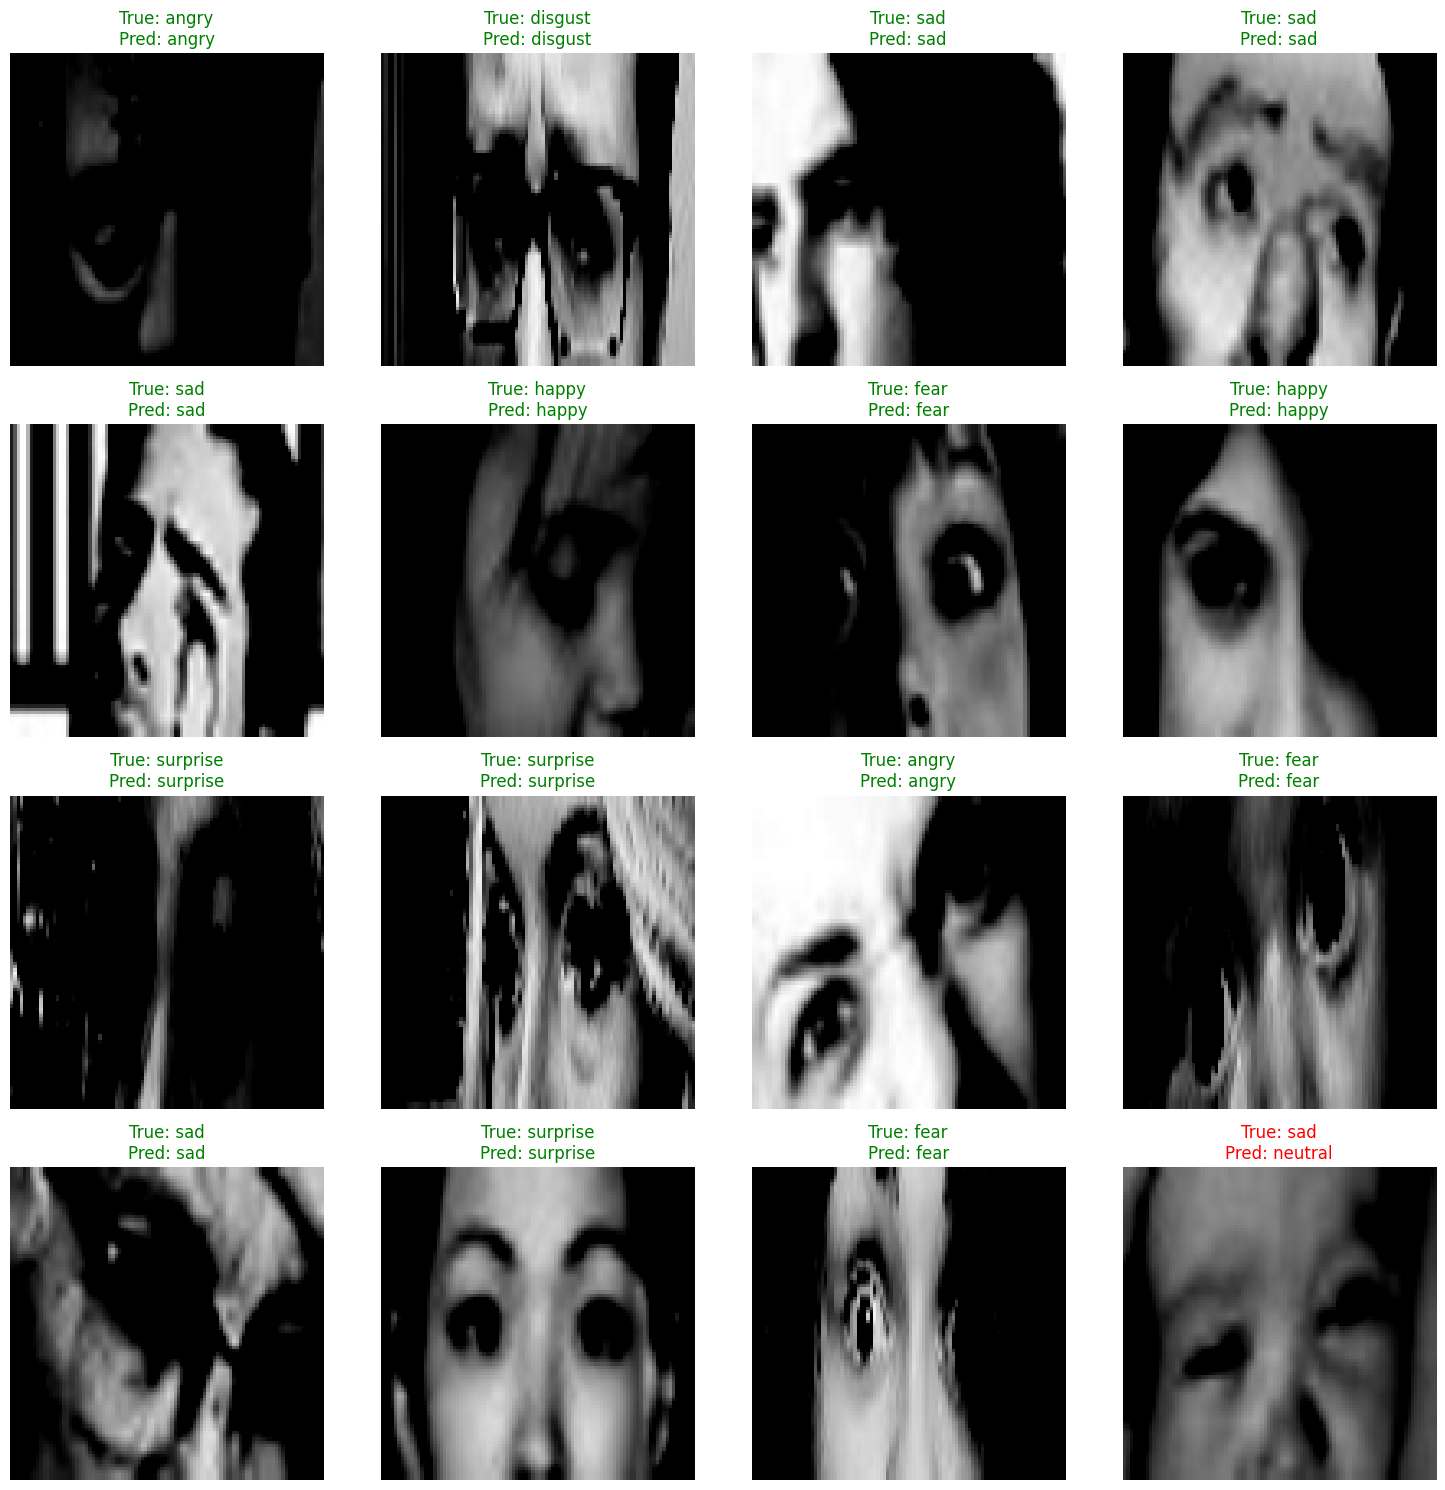

In [ ]:
# Visualize 16 random predictions from the test set
visualize_predictions(model, test_loader, full_dataset.classes, device, num_images=16)

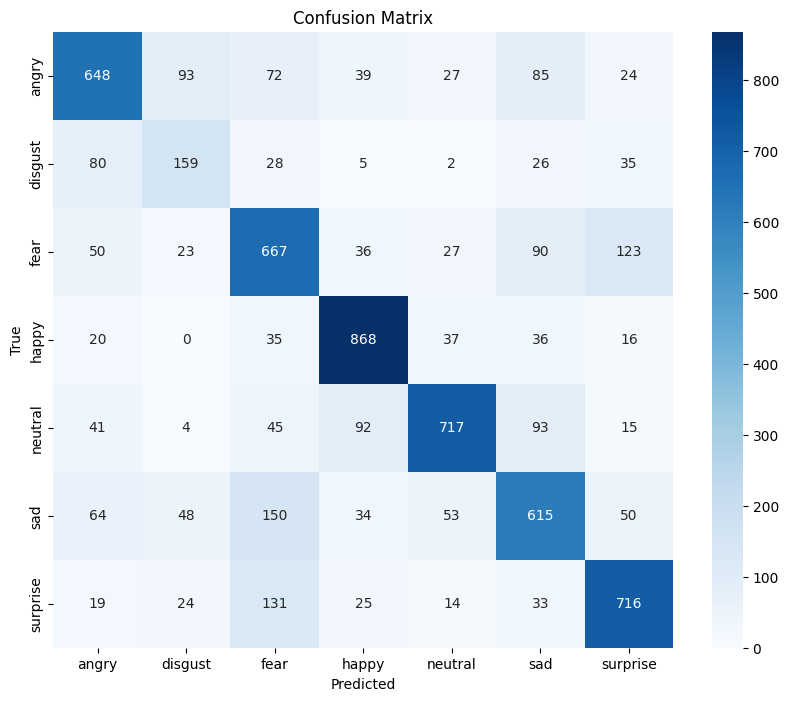

In [27]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Use the external plotting function
plot_confusion_matrix(cm, full_dataset.classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.75686276].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.77254903..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..0.75686276].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..0.6627451

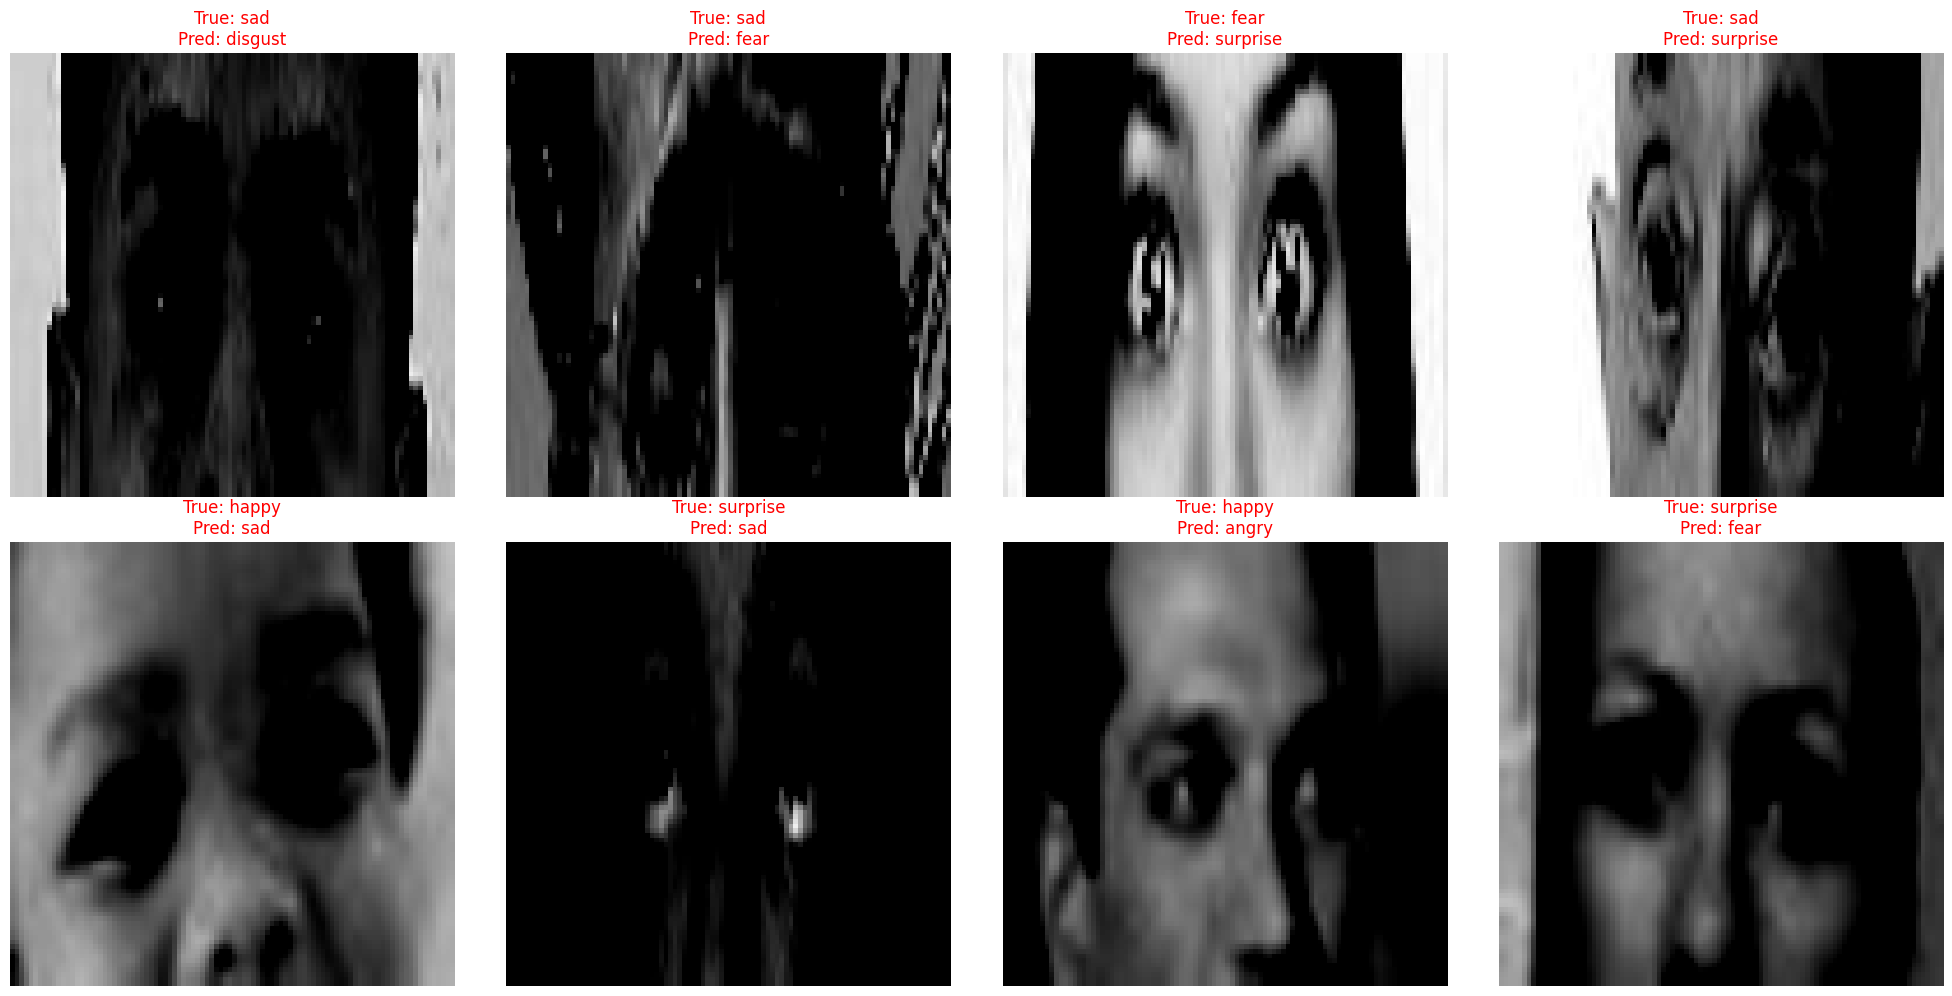

In [ ]:
# Visualize 8 incorrect predictions
visualize_incorrect_predictions(model, test_loader, full_dataset.classes, device, num_images=8)

In [31]:
# Save the final model weights
checkpoint_dir = r'..\checkpoints'
checkpoint_name = 'final_model.pth'
checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)

# Check if the file already exists
if os.path.isfile(checkpoint_path):
    print(f"File {checkpoint_name} already exists. Generating a new unique filename.")
    # Generate a unique filename, e.g., final_model_1, final_model_2, etc.
    base, ext = os.path.splitext(checkpoint_name)
    
    counter = 1
    while True:
        new_name = f"{base}_{counter}{ext}"  # e.g. final_model_1.pth
        new_path = os.path.join(checkpoint_dir, new_name)
        if not os.path.isfile(new_path):
            checkpoint_path = new_path
            break
        counter += 1

# Now save the model to `checkpoint_path`
torch.save(model.state_dict(), checkpoint_path)
print(f"Final model saved as '{checkpoint_path}'")

Final model saved as '..\checkpoints\final_model.pth'


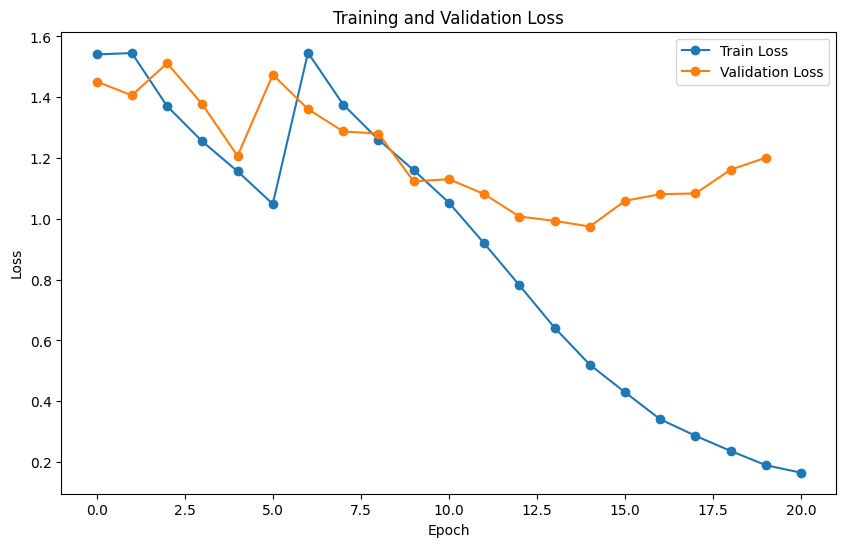

In [32]:
# Plot the loss curves
plot_loss_curves(train_losses, val_losses)